In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

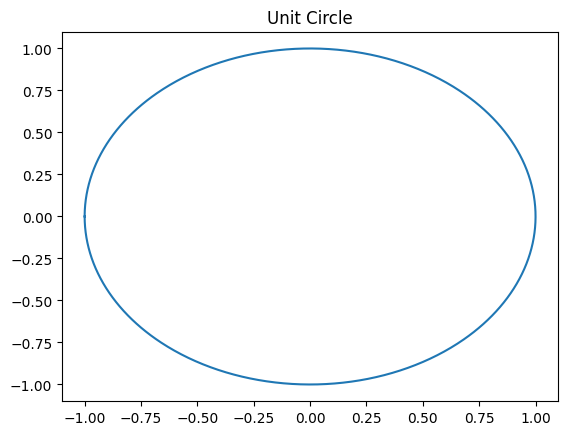

In [5]:
theta = np.linspace(-np.pi, np.pi, num=1000)
x_vals = np.cos(theta)
y_vals = np.sin(theta)

plt.plot(x_vals, y_vals)
plt.title('Unit Circle')
plt.show()